# KNN Implementation for Student Performance Analysis

This implementation provides a comprehensive KNN analysis for student performance data for each subject.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, roc_auc_score
)
from IPython.display import display, Markdown


# Load the CSV file
df = pd.read_csv('graded_exams.csv')

# Display dataset
df

,student,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,math grade,reading score,reading grade,writing score,writing grade
0,0,male,group A,high school,standard,completed,67,Failure,67,Failure,63,Failure
1,1,female,group D,some high school,free/reduced,none,40,Failure,59,Failure,55,Failure
2,2,male,group E,some college,free/reduced,none,59,Failure,60,Failure,50,Failure
3,3,male,group B,high school,standard,none,77,Below Average,78,Below Average,68,Failure
4,4,male,group E,associate's degree,standard,completed,78,Below Average,73,Passing,68,Failure
...,...,...,...,...,...,...,...,...,...,...,...,...
994,995,male,group C,high school,standard,none,73,Passing,70,Failure,65,Failure
995,996,male,group D,associate's degree,free/reduced,completed,85,Above Average,91,Good,92,Superior
996,997,female,group C,some high school,free/reduced,none,32,Failure,35,Failure,41,Failure
997,998,female,group C,some college,standard,none,73,Passing,74,Passing,82,Average




Now let's continue with data preprocessing and model building:



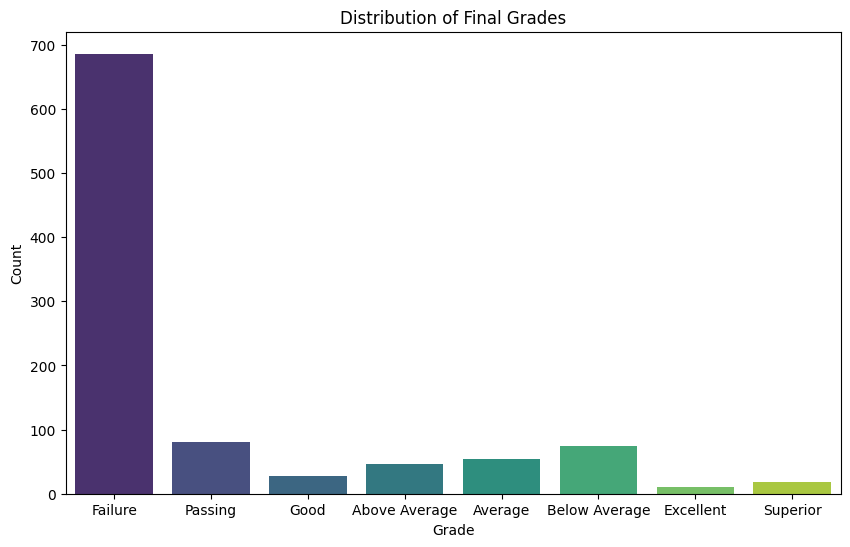

In [28]:
# Grading function based on the grade to be used for visualizing the mean grade distribution
def assign_grade(score):
    if 97 <= score <= 100:
        return 'Excellent'
    elif 93 <= score <= 96:
        return 'Superior'
    elif 89 <= score <= 92:
        return 'Good'
    elif 85 <= score <= 88:
        return 'Above Average'
    elif 81 <= score <= 84:
        return 'Average'
    elif 77 <= score <= 80:
        return 'Below Average'
    elif 73 <= score <= 76:
        return 'Passing'
    else:
        return 'Failure'

# Calculate average score and assign final grade
df['average_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)
df['grade'] = df['average_score'].apply(assign_grade)


# Visualize grade distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='grade', data=df, palette='viridis', hue='grade')
plt.title('Distribution of Final Grades')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

df.drop(['average_score', 'grade'], axis=1, inplace=True)

Let's prepare the data by splitting the data set int 70% for training, 20% for testing, and 10% for the unseen data, then scale the features for kNN for distance calculation.

In [22]:
def prepare_data(df, subject):
    """Prepare features and target, split data, and scale features."""
    # Prepare features and target
    X = df.drop(columns=[f'{subject} grade'])
    X = pd.get_dummies(X, drop_first=True)  # One-hot encode categorical features
    y = df[f'{subject} grade']

    # Encode target labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Split 70% training, 20% testing, 10% unseen
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_test, X_unseen, y_test, y_unseen = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_unseen_scaled = scaler.transform(X_unseen)
    
    return X_train_scaled, X_test_scaled, X_unseen_scaled, y_train, y_test, y_unseen

Function to find the most optimal k distance.

In [23]:
def find_optimal_k(X_train_scaled, y_train):
    """Find optimal K value using cross-validation."""
    k_range = list(range(1, 31))
    cv_scores = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train_scaled, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # Find optimal K value
    optimal_k = k_range[np.argmax(cv_scores)]
    best_score = max(cv_scores)
    
    return optimal_k, best_score

Evalutation function for displaying the model metrics, additionally the function returns the predictions

In [24]:
def evaluate_model(model, X_scaled, y_true, data_type="Test"):
    """Evaluate model on given dataset."""
    # Get predictions
    y_pred = model.predict(X_scaled)
    y_proba = model.predict_proba(X_scaled)
    
    # Print evaluation metrics with fixed zero_division parameter
    print(f"\n{data_type} Evaluation:")
    print(f" {data_type} Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f" Precision: {precision_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(f" Recall: {recall_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(f" ROC-AUC: {roc_auc_score(y_true, y_proba, multi_class='ovr'):.4f}")
    
    return y_pred

Function for plotting the confusion matrix.

In [25]:
def plot_confusion_matrix(y_true, y_pred, subject, data_type="Test"):
    """Plot confusion matrix."""
    plt.figure(figsize=(8, 6))
    cmap = 'Blues' if data_type == "Test" else 'Oranges'
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap=cmap)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {subject} {data_type} Data")
    plt.show()

Now let's create a function to analyze each subject separately:

In [26]:
def process_subject_knn(subject):
    """Process KNN modeling for a given subject."""
    # Prepare data
    X_train_scaled, X_test_scaled, X_unseen_scaled, y_train, y_test, y_unseen = prepare_data(df, subject)
    
    # Find optimal K
    optimal_k, best_score = find_optimal_k(X_train_scaled, y_train)
    
    # Display results header
    display(Markdown(f"# KNN Model for {subject}"))
    print(f"Optimal K value for {subject}: {optimal_k}")
    print(f"Best cross-validation accuracy: {best_score:.4f}")
    
    # Train model with optimal K
    knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
    knn_model.fit(X_train_scaled, y_train)
    
    # Evaluate on test data
    y_test_pred = evaluate_model(knn_model, X_test_scaled, y_test, "Test")
    plot_confusion_matrix(y_test, y_test_pred, subject, "Test")
    
    # Evaluate on unseen data
    y_unseen_pred = evaluate_model(knn_model, X_unseen_scaled, y_unseen, "Unseen")
    plot_confusion_matrix(y_unseen, y_unseen_pred, subject, "Unseen")

Finally, let's apply the KNN analysis to each subject:

# KNN Model for math

Optimal K value for math: 21
Best cross-validation accuracy: 0.6395

Test Evaluation:
 Test Accuracy: 0.6550
 Precision: 0.5525
 Recall: 0.6550
 ROC-AUC: 0.8020


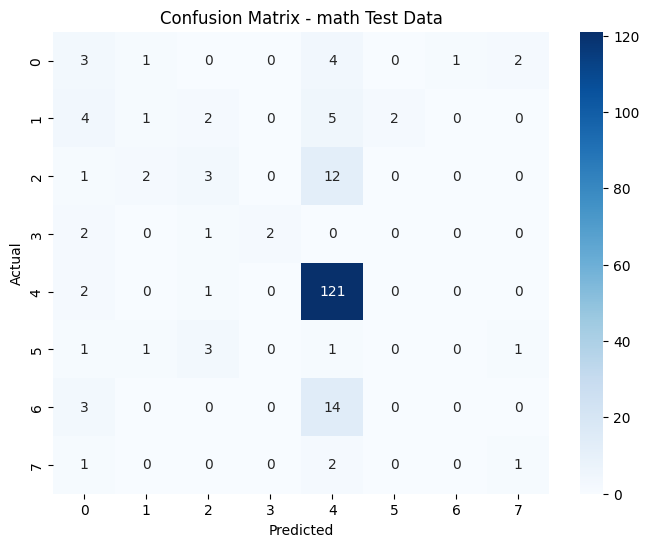


Unseen Evaluation:
 Unseen Accuracy: 0.6000
 Precision: 0.4780
 Recall: 0.6000
 ROC-AUC: 0.7778


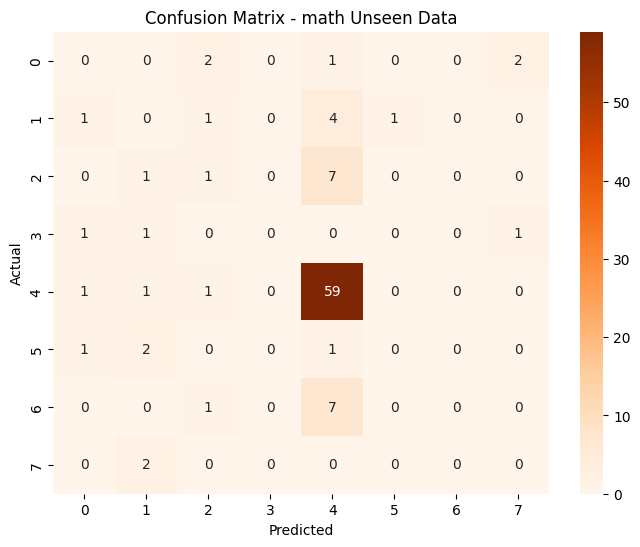

# KNN Model for reading

Optimal K value for reading: 7
Best cross-validation accuracy: 0.6424

Test Evaluation:
 Test Accuracy: 0.6400
 Precision: 0.6012
 Recall: 0.6400
 ROC-AUC: 0.8398


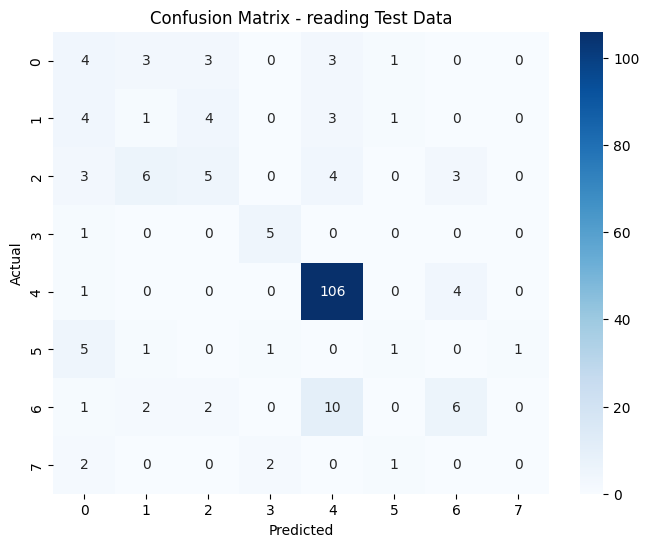


Unseen Evaluation:
 Unseen Accuracy: 0.7000
 Precision: 0.6642
 Recall: 0.7000
 ROC-AUC: 0.8890


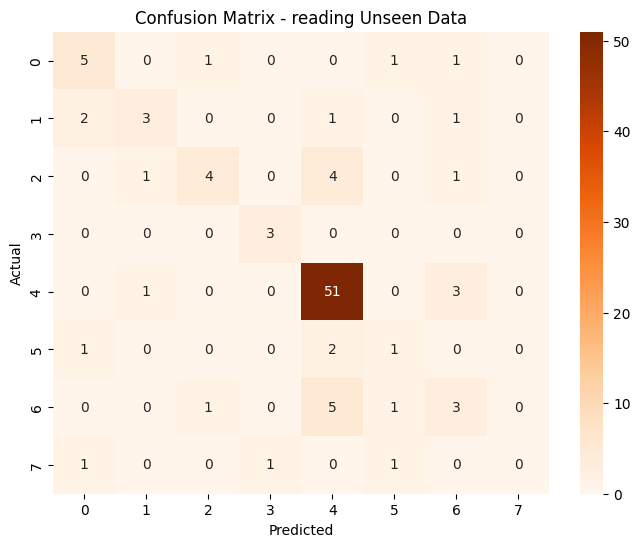

# KNN Model for writing

Optimal K value for writing: 9
Best cross-validation accuracy: 0.6910

Test Evaluation:
 Test Accuracy: 0.6850
 Precision: 0.6283
 Recall: 0.6850
 ROC-AUC: 0.8267


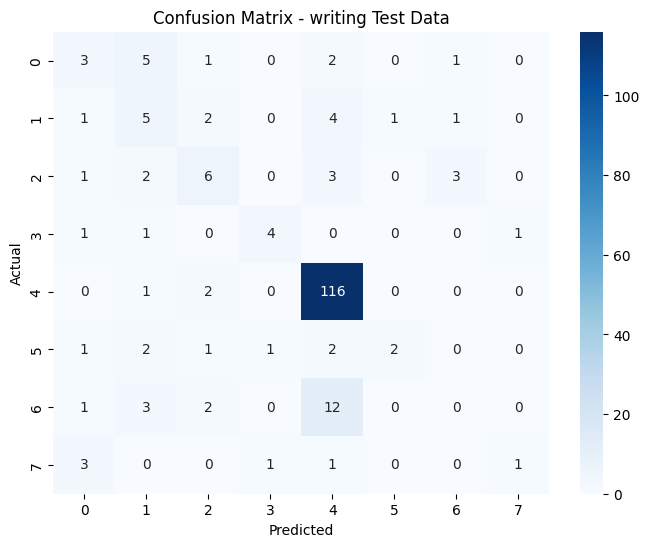


Unseen Evaluation:
 Unseen Accuracy: 0.6500
 Precision: 0.5667
 Recall: 0.6500
 ROC-AUC: 0.7790


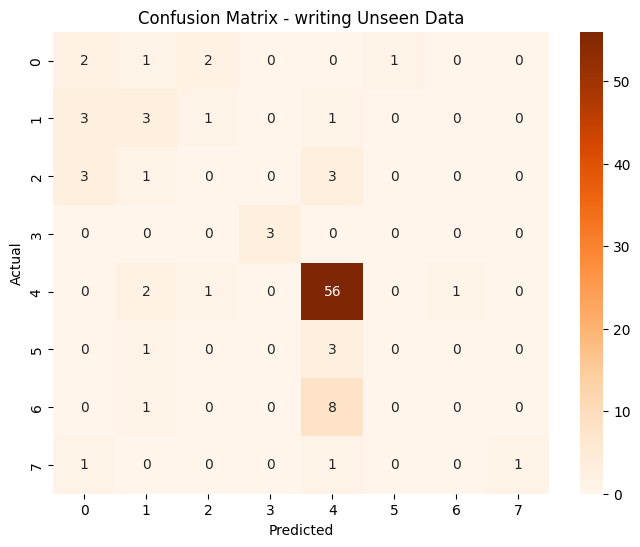

In [27]:
# Process each subject separately
for subject in ['math', 'reading', 'writing']:
    process_subject_knn(subject)